# Deep metric learning for content-based image retrieval



- https://github.com/KinWaiCheuk/Triplet-net-keras/blob/master/Triplet%20NN%20Test%20on%20MNIST.ipynb

# Test triplet

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, sys, glob
import numpy as np
import pandas as pd
from IPython.display import SVG 

In [2]:
# reload my utilities at every cell execution 
%load_ext autoreload
%autoreload 2
# get absolute path of module (root)
module_path = os.path.abspath(os.path.join('../../src'))

# add to PYTHONPATH
if module_path not in sys.path:
    sys.path.append(module_path)
    #print(sys.path)

# import module
from networks import TripletNetwork
from data_generator import DataGenerator

#import image_similarity_metrics

Using TensorFlow backend.


In [3]:
def set_keras_memory_session():
    from keras.backend.tensorflow_backend import set_session
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    #config.log_device_placement = True  # to log device placement (on which device the operation ran)
    sess = tf.Session(config=config)
    set_session(sess)  # set this TensorFlow session as the default session for Keras
set_keras_memory_session()

In [4]:
h, w = 128, 256

# Get image data

In [5]:
def read_image(path):
    from imageio import imread
    from skimage.transform import resize
    
    if path.endswith('.tif'):
        path = path[:-4]+'.png'
    if os.path.dirname(path) == '':
        path = '/data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/thumbnails/' + path
    
    try:
        img = imread(path).astype(np.float32)
    except:
        return None
    if img.ndim != 2:
        return None
    img /= 255.
    img = resize(img, (h,w))
    #img = np.flipud(img)
    #print(img.shape)
    return img

In [6]:
data_folder = '/data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/thumbnails/'

/data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/thumbnails/B706F1F4EB400A6FDA3C6061E569DB.png
/data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/thumbnails/C650BEFCCF16350042CC7E28A932C0.png


NameError: name 'image_similarity_metrics' is not defined

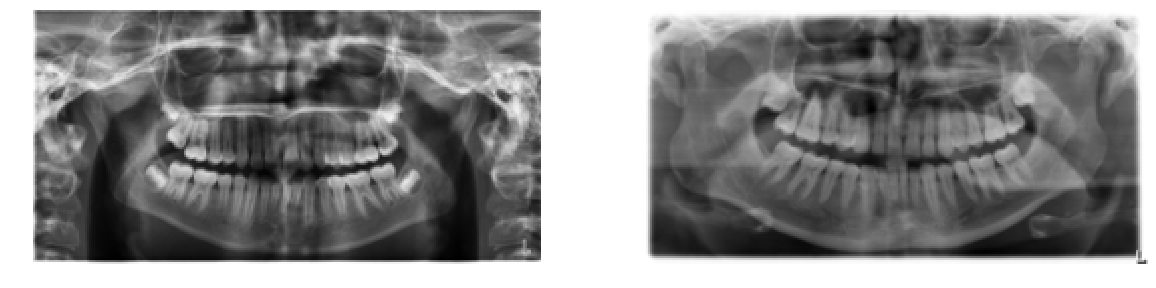

In [39]:
filenames = sorted(glob.glob(os.path.join(data_folder, '*.png')))

# choose two images at random
random_pair = np.random.choice(filenames, size=2)
img_pair = [read_image(s) for s in random_pair]

# plot the images
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(np.squeeze(img_pair[0]), cmap='gray')
ax[1].imshow(np.squeeze(img_pair[1]), cmap='gray')
for a in ax: a.axis('off')

# compute all distance metrics
distance_metrics = [f for f in dir(image_similarity_metrics) if f.endswith('_distance')]
print(distance_metrics)
for metric in distance_metrics:
    value = getattr(image_similarity_metrics, metric)(*img_pair)
    print(f'{metric} = {value:.9f}')


# Load data

- dataframe
- pairwise distance matrices

In [7]:
data_folder = '../../output/data/'

In [8]:
pdist_age = np.load(os.path.join(data_folder, 'pdist_age.npy'))
pdist_cae = np.load(os.path.join(data_folder, 'pdist_cae.npy'))
df = pd.read_csv(os.path.join(data_folder, 'dataframe_triplet.csv'))

# Initialize data generator

In [172]:
from data_generator import DataGenerator

#fraction_test = 0.25
#train_df, test_df  = np.split(df, [int(len(df)*(1.0-fraction_test))], axis=0)
#print(len(train_df), len(test_df))
generator = DataGenerator(dataframe=df, 
                          distance_matrices=[pdist_age, pdist_cae],
                          batch_size=4, 
                          augmentation=True,
                          verbose=False)

batch = generator.__getitem__(0)

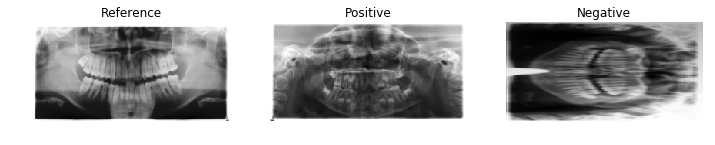

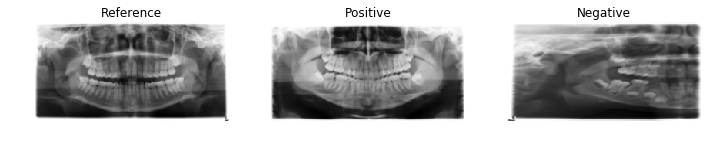

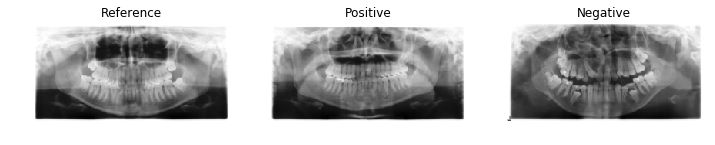

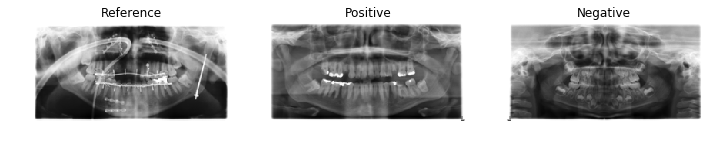

In [173]:
generator.plot_batch()

# Build Triplet Network model

In [198]:
def base_model(input_shape):
    """
    Base network to be shared.
    """
    from keras import layers, models
    
    n_init_filters = 64
    i = layers.Input(input_shape)
    x = layers.Conv2D(n_init_filters, (3,3), padding='valid', activation='relu')(i)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(n_init_filters*2, (3,3), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(n_init_filters*4, (3,3), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    o = layers.GlobalAveragePooling2D()(x)
    return models.Model(inputs=i, outputs=o)

In [199]:
basemodel = base_model((128,256,1))

In [200]:
model = TripletNetwork(input_shape=(h, w, 1), backbone=basemodel) #backbone='inception_v3')

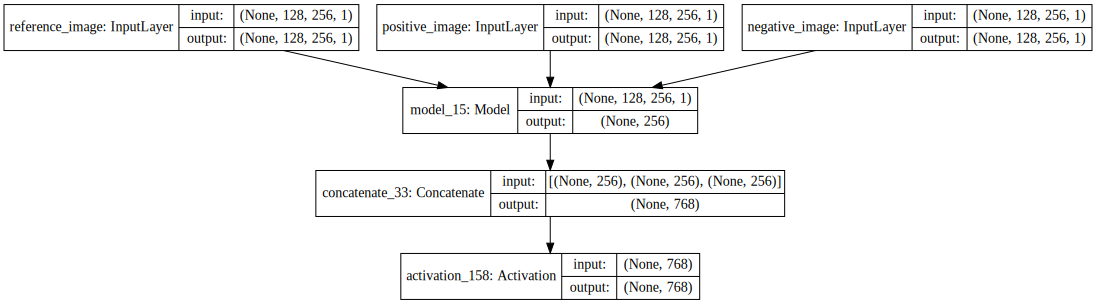

In [201]:
SVG(model.plot(shapes=True, names=True))

In [202]:
y_pred = model.model.predict_generator(generator, steps=1)
y_pred.shape

KeyboardInterrupt: 

In [ ]:
#y_pred

In [203]:
from losses import triplet_loss
K.eval( triplet_loss(y_pred, y_pred) )

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

In [204]:
model.model.fit_generator(generator, 
                          steps_per_epoch=1,
                          epochs=50,
                          validation_steps=10,
                          use_multiprocessing=True, workers=6,
                          verbose=1)

Epoch 1/50
1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 44ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 37ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 39ms/step - loss: 28.5293
Epoch 8/50
1/1 [==============================] - 0s 52ms/step - loss: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 53ms/step - loss: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 39ms/step - loss: 8.5235
Epoch 11/50
1/1 [==============================] - 0s 48ms/step - loss: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 54ms/step - loss: 0.0000e+00
Epoch 13/50
1/1 [===

# Get encodings from trained submodel

In [59]:
def read_image(path, img_folder):
        from imageio import imread
        from skimage.transform import resize

        if path.endswith('.tif'):
            path = path[:-4]+'.png'
        if os.path.dirname(path) == '':
            path = img_folder + path
        try:
            img = imread(path).astype(np.float32)
        except:
            return None
        if img.ndim != 2:
            return None
        img /= 255.
        img = resize(img, (h,w))
        img = img[..., np.newaxis]
        return img

In [60]:
import math
from tqdm import tqdm as tqdm
def chunks(arr, max_size):
    num_chunks = math.ceil(arr.shape[0] / max_size)
    return np.array_split(arr, num_chunks)

img_folder = '/data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/thumbnails/'
batch_size = 30
outputs = []
for batch in chunks(df['NewFile'].values, batch_size):
    
    # read images (in parallel)
    from joblib import Parallel, delayed
    ims = np.array(Parallel(n_jobs=-1)(delayed(read_image)(fn, img_folder=img_folder) for fn in batch))
    #ims = np.array([read_image(fn, img_folder=img_folder) for fn in batch])
    
    # get encodings from triplet basemodel
    output = model.submodel.predict_on_batch(ims)
    outputs.append(output)
    
    #plt.matshow(output, aspect='auto')
    #plt.show()
    #plt.close()

outputs = [item for sublist in outputs for item in sublist]
df['Triplet encoding'] = outputs


KeyboardInterrupt: 

In [66]:
df['Triplet encoding'] = outputs


In [71]:
df.to_csv('../../output/data/dataframe_triplet_encodings.csv')

KeyboardInterrupt: 

# Nearest neighbors

In [104]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=100, radius=1.0, algorithm='kd_tree')

In [105]:
x = np.vstack( df['Triplet encoding'].values )
neighbors.fit(x)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                 radius=1.0)

# Find nearest neighbors

In [153]:
def get_nearest_neighbors(encoding, age, n_neighbors=50):
    '''
    
    Args:
        encoding (array, shape=(1,512))
        neighbors (sklearn.neighbors.NearestNeighbors): 
    '''

    
    nbs_indices = neighbors.kneighbors(encoding, n_neighbors=n_neighbors, return_distance=False)[0]
    df_neighbors = df.iloc[nbs_indices]
    
    # get images of neighbors
    from joblib import Parallel, delayed
    ims = np.array(Parallel(n_jobs=-1)(delayed(read_image)(fn, img_folder=img_folder) for fn in df_neighbors['NewFile']))

    # plot reference image and histogram
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].imshow(np.squeeze(ims[0]), cmap='gray'); ax[0].set_title(f'Reference (age = {age})'); ax[0].axis('off')
    ax[1].hist(df_neighbors['Age']);

    # plot neighbors
    nc = nr = int(np.ceil(np.sqrt(len(ims))))
    fig, ax = plt.subplots(nr, nc, figsize=(24,12))
    ax = ax.flatten()
    for i, im in enumerate(ims):
        ax[i].imshow(np.squeeze(im), cmap='gray')
        ax[i].axis('off')
    for a in ax[i+1:]: a.set_visible(False)

    plt.show()
    plt.close()


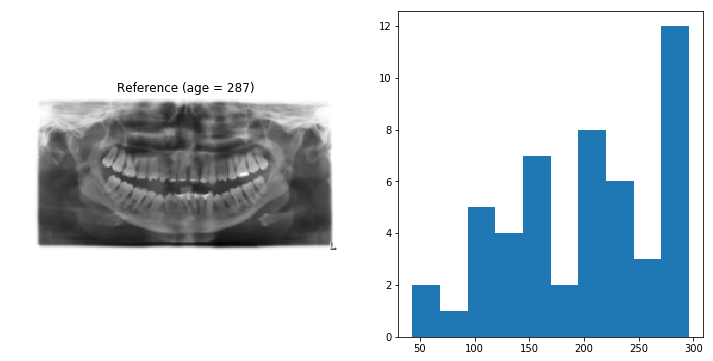

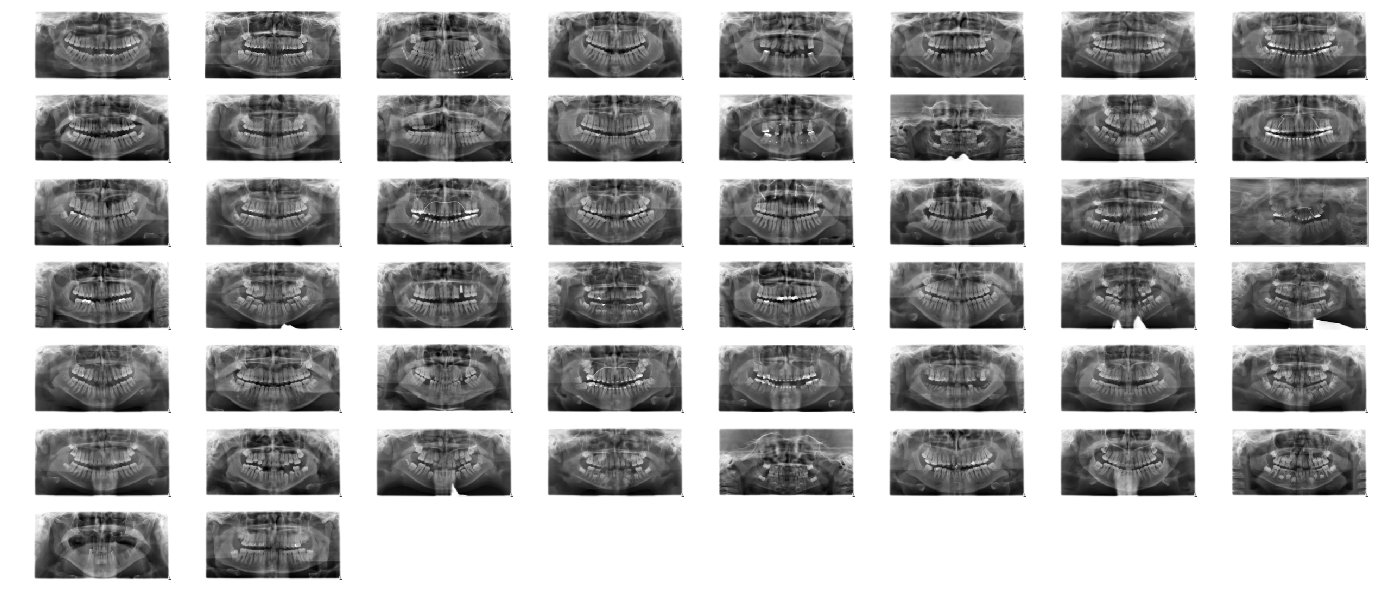

In [154]:
sample = 2
code = df.iloc[sample]['Triplet encoding']
code = code[np.newaxis, ...]
age = df.iloc[sample]['Age']
get_nearest_neighbors(code, age)

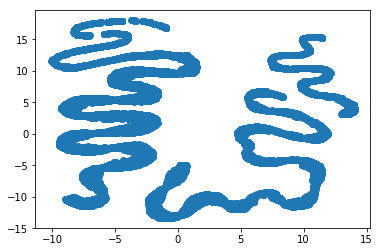

In [137]:
import umap 
reducer = umap.UMAP()
embedding = reducer.fit_transform(np.vstack( df['Triplet encoding'].values ))
plt.scatter(*embedding.T)



In [140]:
df['Age']

0        110
1        285
2        287
3        254
4        262
5        251
6        298
7        187
8        183
9        195
10       185
11       187
12       224
13       209
14       257
15       231
16       148
17       166
18       177
19       175
20       173
21       124
22       173
23       129
24       283
25       273
26       295
27       296
28       271
29       266
        ... 
18252    285
18253    296
18254    295
18255     60
18256    215
18257    267
18258    287
18259    263
18260    263
18261    297
18262    242
18263    222
18264    265
18265    209
18266    250
18267    241
18268    184
18269    225
18270    298
18271    251
18272    286
18273    238
18274    192
18275    221
18276     53
18277     54
18278    242
18279    240
18280    243
18281    276
Name: Age, Length: 18282, dtype: int64